## LATIHAN ARIMA-TRANSFORMER

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm, shapiro, anderson
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest

In [2]:
import tensorflow as tf
import keras

print(tf.__version__, keras.__version__)

2.18.0 3.8.0


In [3]:
data_df = pd.read_excel('residual_sarima.xlsx')
columns_name = ['Residual']
Data = pd.DataFrame(data_df, columns=columns_name)
time_series_numpy = Data.values.astype(float)  # Replace 'your_column_name' with the actual column name

# Seasonal features (assuming you have a time index)
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d%m%Y')
data_df.set_index('Date', inplace=True)

In [4]:
print(data_df.columns)

Index(['Number', 'Residual'], dtype='object')


In [5]:
Data.tail()

,Residual
414,9.850500
415,12.558455
416,6.015926
417,-2.654686
418,12.024296


In [6]:
def add_lag_features(data_df, lags):
    for lag in lags:
        column_name_lag = f'lag_{lag}'
        data_df[column_name_lag] = data_df['Residual'].shift(lag)

def add_rolling_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_min = f'rolling_min_{window_size}'
        column_name_max = f'rolling_max_{window_size}'
        column_name_ma = f'moving_average_{window_size}'
        column_name_ema = f'ema_{window_size}'
        column_name_std = f'moving_std_{window_size}'
        column_name_median = f'moving_median_{window_size}'

        data_df[column_name_min] = data_df['Residual'].rolling(window=window_size).min()
        data_df[column_name_max] = data_df['Residual'].rolling(window=window_size).max()
        data_df[column_name_ma] = data_df['Residual'].rolling(window=window_size).mean()
        data_df[column_name_ema] = data_df['Residual'].ewm(span=window_size, adjust=False).mean()
        data_df[column_name_std] = data_df['Residual'].rolling(window=window_size).std()
        data_df[column_name_median] = data_df['Residual'].rolling(window=window_size).median()

def add_interaction_features(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_interaction = f'interaction_ma_ema_{window_size}'
        data_df[column_name_interaction] = data_df[f'moving_average_{window_size}'] * data_df[f'ema_{window_size}']

def add_seasonal_features(data_df):
    data_df['quarter'] = data_df.index.quarter
    data_df['year'] = data_df.index.year

def add_rate_of_change(data_df, lags):
    for lag in lags:
        column_name_roc = f'roc_{lag}'
        data_df[column_name_roc] = (data_df['Residual'] - data_df['Residual'].shift(lag)) / data_df['Residual'].shift(lag)

def add_cumulative_sum(data_df):
    data_df['cumulative_sum'] = data_df['Residual'].cumsum()

def add_ewma_std(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_ewma_std = f'ewma_std_{window_size}'
        data_df[column_name_ewma_std] = data_df['Residual'].ewm(span=window_size, adjust=False).std()

def add_additional_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_lagged_ma = f'lagged_ma_{window_size}'
        column_name_lagged_ema = f'lagged_ema_{window_size}'
        column_name_acf = f'autocorr_{window_size}'

        data_df[column_name_lagged_ma] = data_df[f'moving_average_{window_size}'].shift(1)
        data_df[column_name_lagged_ema] = data_df[f'ema_{window_size}'].shift(1)
        data_df[column_name_acf] = data_df['Residual'].autocorr(lag=window_size)

def add_z_scores(data_df):
    # Z-Score based on standard deviation
    data_df['z_score'] = (data_df['Residual'] - data_df['Residual'].mean()) / data_df['Residual'].std()

    # Z-Score based on median and median absolute deviation (MAD)
    median = data_df['Residual'].median()
    mad = np.median(np.abs(data_df['Residual'] - median))
    data_df['mad_z_score'] = (data_df['Residual'] - median) / mad

def add_log_returns(data_df):
    data_df['log_returns'] = np.log(data_df['Residual'] / data_df['Residual'].shift(1))


# List of lags for lag features
lags = [1, 2, 3]
# Lags represent the time intervals used to shift and create lag features, capturing historical values at different points in the past.

# List of window sizes for rolling statistics and other features
window_sizes = [2, 3, 12, 24, 28, 36]
# Window sizes determine the size of the rolling windows used for calculating statistics and features. Different sizes capture varying trends and patterns over specified periods.


add_lag_features(data_df, lags)
add_rolling_statistics(data_df, window_sizes)
add_interaction_features(data_df, window_sizes)
add_seasonal_features(data_df)
add_rate_of_change(data_df, lags)
add_cumulative_sum(data_df)
add_ewma_std(data_df, window_sizes)
add_additional_statistics(data_df, window_sizes)
add_z_scores(data_df)
add_log_returns(data_df)

data_df_drop = data_df.dropna()

In [7]:
data_df_drop.head()

,Number,Residual,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,moving_std_2,...,autocorr_24,lagged_ma_28,lagged_ema_28,autocorr_28,lagged_ma_36,lagged_ema_36,autocorr_36,z_score,mad_z_score,log_returns
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-01,37,115.702636,104.234702,-108.415779,-128.321213,104.234702,115.702636,109.968669,88.979953,8.109054,...,0.02976,-17.539892,-33.205449,-0.121998,-10.234614,-49.102984,-0.044641,1.841510,3.711603,0.104378
1990-06-01,42,45.191793,9.837259,-46.714124,114.662819,9.837259,45.191793,27.514526,32.003287,24.999431,...,0.02976,-2.808450,-13.022555,-0.121998,-1.710034,-28.759323,-0.044641,0.670262,1.453498,1.524738
1990-09-01,45,52.504205,43.652695,-51.182487,45.191793,43.652695,52.504205,48.078450,42.097414,6.258963,...,0.02976,-2.207653,-8.084024,-0.121998,-7.382210,-22.414815,-0.044641,0.791728,1.687677,0.184628
1990-10-01,46,125.400823,52.504205,43.652695,-51.182487,52.504205,125.400823,88.952514,97.633020,51.545693,...,0.02976,2.095405,-3.905525,-0.121998,-4.460719,-18.365138,-0.044641,2.002605,4.022187,0.870622
1990-11-01,47,24.317237,125.400823,52.504205,43.652695,24.317237,125.400823,74.859030,48.755831,71.476889,...,0.02976,10.913473,5.012154,-0.121998,2.229925,-10.594005,-0.044641,0.323517,0.784991,-1.640330


In [8]:
data_df_drop.tail()

,Number,Residual,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,moving_std_2,...,autocorr_24,lagged_ma_28,lagged_ema_28,autocorr_28,lagged_ma_36,lagged_ema_36,autocorr_36,z_score,mad_z_score,log_returns
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,411,30.114724,56.138927,27.261595,-5.240954,30.114724,56.138927,43.126825,34.934361,18.401891,...,0.02976,24.395099,25.749239,-0.121998,19.283800,23.723717,-0.044641,0.419819,0.970655,-0.622815
2021-05-01,413,-37.858644,-52.288836,30.114724,56.138927,-52.288836,-37.858644,-45.073740,-32.977242,10.203686,...,0.02976,22.882909,20.647607,-0.121998,20.559076,19.941717,-0.044641,-0.709279,-1.206187,-0.322924
2021-06-01,414,-26.315747,-37.858644,-52.288836,30.114724,-37.858644,-26.315747,-32.087196,-28.536246,8.162061,...,0.02976,22.014091,16.612693,-0.121998,20.771727,16.817373,-0.044641,-0.517542,-0.836527,-0.363692
2021-08-01,416,12.558455,9.850500,-26.315747,-37.858644,9.850500,12.558455,11.204477,7.390609,1.914814,...,0.02976,19.004461,13.389931,-0.121998,23.324576,14.235293,-0.044641,0.128193,0.408417,0.242872
2021-09-01,417,6.015926,12.558455,9.850500,-26.315747,6.015926,12.558455,9.287191,6.474154,4.626267,...,0.02976,20.076874,13.332588,-0.121998,18.544350,14.144653,-0.044641,0.019516,0.198893,-0.735984


In [9]:
# Convert DataFrame to NumPy array
features_array = data_df_drop.to_numpy()

# Create input and output dataframes
input_data = pd.DataFrame(data_df_drop, columns=data_df.columns)
input_data1 = input_data.iloc[:-1, :]
output_data = input_data.iloc[1:, 0]

# Convert to NumPy arrays
features = input_data1.to_numpy()
target = output_data.to_numpy()

# Standardize features
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

# Standardize target variable
target_scaler = StandardScaler()
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

In [10]:
def feature_metrics(features, target):
    # 1. F-statistic (ANOVA)
    f_stat, p_values_anova = f_regression(features, target)

    # 2. Random Forest Feature Importance
    rf_model = RandomForestRegressor()
    rf_model.fit(features, target)
    rf_feature_importances = rf_model.feature_importances_

    # 3. Mutual Information
    mutual_info_scores = mutual_info_regression(features, target)

    # 4. Principal Component Analysis (PCA)
    pca = PCA()
    pca.fit(features)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Return the selected features based on each method
    selected_features = {
        'f_stat': f_stat,
        'rf_feature_importances': rf_feature_importances,
        'mutual_info_scores': mutual_info_scores,
        'explained_variance_ratio': explained_variance_ratio,
        }

    return selected_features

In [11]:
def rank_and_top_features(scores, top_n=10):
    # Create a new dataframe for ranks
    ranks_df = pd.DataFrame()

    # Assign the ranking for each method
    for col in scores.columns:
        ranks_df[col+'_rank'] = scores[col].rank(ascending=False)

    # Calculate mean rank for each feature
    ranks_df['mean_rank'] = ranks_df.mean(axis=1)

    # Identify the top features based on mean rank
    top_features_index = ranks_df.nsmallest(top_n, 'mean_rank').index

    return ranks_df, top_features_index


Top 20 Features Index:
Index(['Number', 'year', 'moving_std_28', 'rolling_min_24', 'rolling_min_12',
       'rolling_min_28', 'moving_std_36', 'moving_std_24', 'cumulative_sum',
       'ewma_std_36', 'rolling_max_36', 'rolling_max_28', 'rolling_min_36',
       'moving_std_12', 'ewma_std_28', 'rolling_max_12', 'moving_average_24',
       'ewma_std_24', 'moving_average_28', 'rolling_max_24'],
      dtype='object')


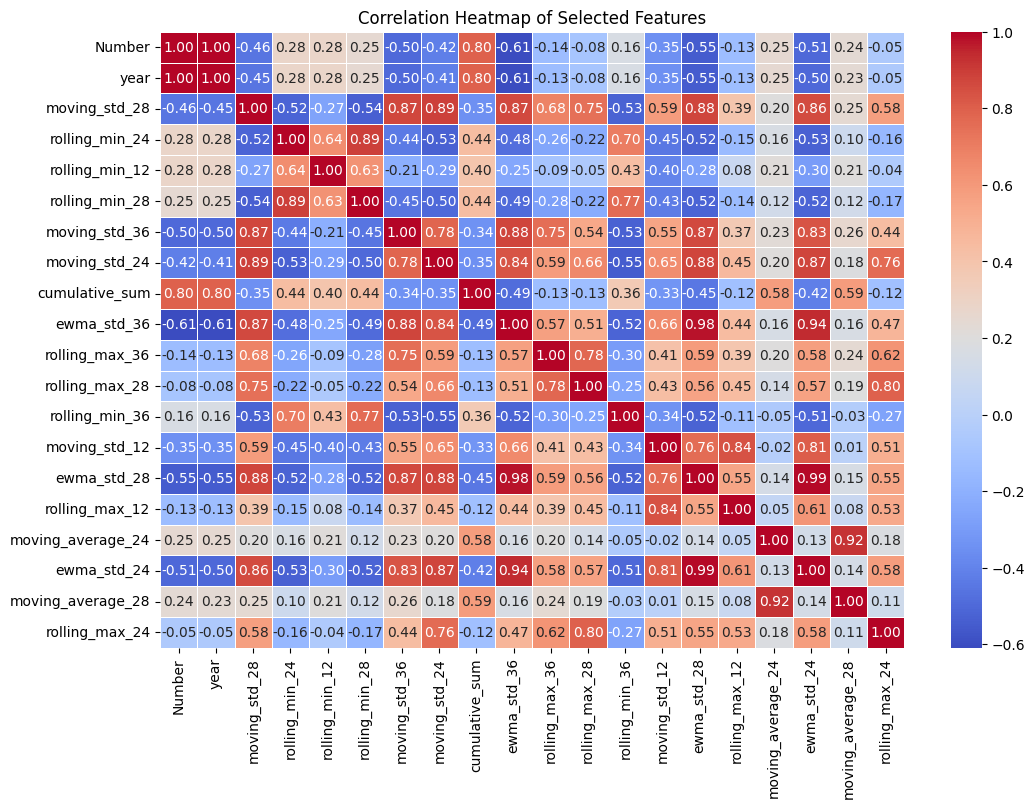

In [12]:
# Calculate and rank features
scores = feature_metrics(features_scaled, scaled_target)
df_scores = pd.DataFrame(scores)
top_n = 20  # Change this to the desired value

# Get ranked scores and top features index
df_scores_ranked, top_features_index = rank_and_top_features(df_scores, top_n=top_n)

# Assuming the features are stored in a DataFrame named 'data_df_drop' with 'Time' as the index
top_features_index_names = data_df_drop.columns[top_features_index]

print(f"\nTop {top_n} Features Index:")
print(top_features_index_names)

# Extract the top features from the original DataFrame
selected_features_df = data_df_drop[top_features_index_names]

correlation_matrix = selected_features_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

extracted_features_data = selected_features_df.to_numpy()

In [13]:
def prepare_time_series_data(data, time_steps=28, test_size=0.3, random_state=42):
    """
    Prepare time series data for training and testing.

    Parameters:
    - data: The time series data.
    - time_steps: Number of time steps to consider for each sample.
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: Seed used by the random number generator.

    Returns:
    - x_train, x_test, y_train, y_test: Prepared training and testing sets.
    """
    data_scaler = StandardScaler()
    data_scaled = data_scaler.fit_transform(data)

    total_samples, num_features = data_scaled.shape
    n_steps = time_steps

    X = []
    y = []

    for i in range(n_steps, len(data_scaled)):
        X.append(data_scaled[i - n_steps:i, :])
        y.append(data_scaled[i, 0])

    X = np.array(X)
    y = np.array(y)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

    return X, y, x_train, x_test, y_train, y_test

# Example usage:
time_steps = 28
X, y, x_train, x_test, y_train, y_test = prepare_time_series_data(extracted_features_data, time_steps)

print("Training set shapes:")
print(x_train.shape, y_train.shape)

print("\nTesting set shapes:")
print(x_test.shape, y_test.shape)

Training set shapes:
(119, 28, 20) (119,)

Testing set shapes:
(52, 28, 20) (52,)


In [14]:
# Assuming x_train, x_test, y_train, y_test are already prepared
# Using the same shapes you provided (2 time steps, 20 features)

import tensorflow.keras.backend as K

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model_lstm.add(Dense(units=25, activation='relu'))  # Output layer with 1 neuron for regression tasks
model_lstm.add(Dense(units=1))  # Output layer with 1 neuron for regression tasks

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model_lstm.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath1 = 'best_model_lstm.h5'
model_checkpoint1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Train the model
history = model_lstm.fit(
    x_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint1]
)

Epoch 1/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - loss: 0.7204 - mae: 0.7721 - r_squared: -68.1677
Epoch 1: val_loss improved from inf to 0.53984, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 437ms/step - loss: 0.7311 - mae: 0.7766 - r_squared: -51.6602 - val_loss: 0.5398 - val_mae: 0.6699 - val_r_squared: -42.7714
Epoch 2/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.5667 - mae: 0.6783 - r_squared: -66.6665
Epoch 2: val_loss improved from 0.53984 to 0.41771, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.5536 - mae: 0.6683 - r_squared: -50.7972 - val_loss: 0.4177 - val_mae: 0.5834 - val_r_squared: -43.1223
Epoch 3/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.4064 - mae: 0.5654 - r_squared: -69.5258
Epoch 3: val_loss improved from 0.41771 to 0.30575, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.4024 - mae: 0.5622 - r_squared: -52.9118 - val_loss: 0.3057 - val_mae: 0.4947 - val_r_squared: -45.1316
Epoch 4/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3009 - mae: 0.4762 - r_squared: -74.2828
Epoch 4: val_loss improved from 0.30575 to 0.20633, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.2857 - mae: 0.4636 - r_squared: -57.5401 - val_loss: 0.2063 - val_mae: 0.3988 - val_r_squared: -51.5212
Epoch 5/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1807 - mae: 0.3625 - r_squared: -89.3446
Epoch 5: val_loss did not improve from 0.20633
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1760 - mae: 0.3513 - r_squared: -68.3677 - val_loss: 0.2460 - val_mae: 0.3537 - val_r_squared: -74.2747
Epoch 6/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2432 - mae: 0.3418 - r_squared: -137.0608
Epoch 6: val_loss improved from 0.20633 to 0.09142, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.2281 - mae: 0.3378 - r_squared: -103.3014 - val_loss: 0.0914 - val_mae: 0.2537 - val_r_squared: -64.3911
Epoch 7/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0948 - mae: 0.2560 - r_squared: -112.3092
Epoch 7: val_loss did not improve from 0.09142
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0919 - mae: 0.2510 - r_squared: -86.2142 - val_loss: 0.0935 - val_mae: 0.2305 - val_r_squared: -70.4199
Epoch 8/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0924 - mae: 0.2474 - r_squared: -117.7055
Epoch 8: val_loss did not improve from 0.09142
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0900 - mae: 0.2413 - r_squared: -89.9893 - val_loss: 0.1171 - val_mae: 0.2290 - val_r_squared: -80.7961
Epoch 9/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0834 - mae: 0.2299 - r_squared: -124.5867
Epoch 9: val_loss did not improve from 0.09142
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0879 - mae: 0.2298 - r_squared: -97.2769 - val_

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0580 - mae: 0.1920 - r_squared: -102.8052 - val_loss: 0.0695 - val_mae: 0.2204 - val_r_squared: -80.8154
Epoch 12/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0449 - mae: 0.1680 - r_squared: -129.6377
Epoch 12: val_loss improved from 0.06949 to 0.06022, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0419 - mae: 0.1608 - r_squared: -99.9071 - val_loss: 0.0602 - val_mae: 0.1971 - val_r_squared: -73.7763
Epoch 13/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0284 - mae: 0.1357 - r_squared: -124.5710
Epoch 13: val_loss improved from 0.06022 to 0.05884, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0297 - mae: 0.1378 - r_squared: -95.3923 - val_loss: 0.0588 - val_mae: 0.1860 - val_r_squared: -69.2826
Epoch 14/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0235 - mae: 0.1223 - r_squared: -121.5012
Epoch 14: val_loss improved from 0.05884 to 0.05120, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0257 - mae: 0.1259 - r_squared: -92.5336 - val_loss: 0.0512 - val_mae: 0.1694 - val_r_squared: -67.0617
Epoch 15/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0231 - mae: 0.1164 - r_squared: -118.3675
Epoch 15: val_loss improved from 0.05120 to 0.04329, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0231 - mae: 0.1160 - r_squared: -90.4495 - val_loss: 0.0433 - val_mae: 0.1607 - val_r_squared: -66.6546
Epoch 16/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0222 - mae: 0.1072 - r_squared: -118.0810
Epoch 16: val_loss improved from 0.04329 to 0.03866, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0220 - mae: 0.1078 - r_squared: -90.1271 - val_loss: 0.0387 - val_mae: 0.1528 - val_r_squared: -67.0373
Epoch 17/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0244 - mae: 0.1118 - r_squared: -116.7466
Epoch 17: val_loss improved from 0.03866 to 0.03321, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0219 - mae: 0.1057 - r_squared: -89.9993 - val_loss: 0.0332 - val_mae: 0.1428 - val_r_squared: -67.6987
Epoch 18/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0207 - mae: 0.1027 - r_squared: -119.7767
Epoch 18: val_loss improved from 0.03321 to 0.02688, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0189 - mae: 0.0971 - r_squared: -92.0776 - val_loss: 0.0269 - val_mae: 0.1285 - val_r_squared: -68.2601
Epoch 19/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0126 - mae: 0.0774 - r_squared: -123.3173
Epoch 19: val_loss improved from 0.02688 to 0.02196, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0136 - mae: 0.0808 - r_squared: -93.8285 - val_loss: 0.0220 - val_mae: 0.1164 - val_r_squared: -69.0804
Epoch 20/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0120 - mae: 0.0758 - r_squared: -122.6497
Epoch 20: val_loss improved from 0.02196 to 0.01959, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0118 - mae: 0.0760 - r_squared: -94.5475 - val_loss: 0.0196 - val_mae: 0.1115 - val_r_squared: -70.2371
Epoch 21/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0117 - mae: 0.0812 - r_squared: -125.3674
Epoch 21: val_loss improved from 0.01959 to 0.01742, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0112 - mae: 0.0789 - r_squared: -96.4326 - val_loss: 0.0174 - val_mae: 0.1040 - val_r_squared: -71.1922
Epoch 22/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0094 - mae: 0.0732 - r_squared: -128.9993
Epoch 22: val_loss improved from 0.01742 to 0.01413, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0098 - mae: 0.0751 - r_squared: -98.1889 - val_loss: 0.0141 - val_mae: 0.0923 - val_r_squared: -71.9507
Epoch 23/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0092 - mae: 0.0720 - r_squared: -129.9136
Epoch 23: val_loss improved from 0.01413 to 0.01194, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0088 - mae: 0.0705 - r_squared: -98.9589 - val_loss: 0.0119 - val_mae: 0.0844 - val_r_squared: -72.5239
Epoch 24/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0085 - mae: 0.0707 - r_squared: -128.4441
Epoch 24: val_loss improved from 0.01194 to 0.01053, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0080 - mae: 0.0675 - r_squared: -98.7718 - val_loss: 0.0105 - val_mae: 0.0784 - val_r_squared: -72.2580
Epoch 25/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0058 - mae: 0.0595 - r_squared: -127.5953
Epoch 25: val_loss improved from 0.01053 to 0.00913, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0064 - mae: 0.0612 - r_squared: -97.7697 - val_loss: 0.0091 - val_mae: 0.0706 - val_r_squared: -71.0931
Epoch 26/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0058 - mae: 0.0587 - r_squared: -126.2006
Epoch 26: val_loss improved from 0.00913 to 0.00832, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0059 - mae: 0.0594 - r_squared: -96.4303 - val_loss: 0.0083 - val_mae: 0.0683 - val_r_squared: -69.9017
Epoch 27/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0060 - mae: 0.0590 - r_squared: -124.3881
Epoch 27: val_loss improved from 0.00832 to 0.00805, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0057 - mae: 0.0581 - r_squared: -95.2675 - val_loss: 0.0081 - val_mae: 0.0674 - val_r_squared: -69.2590
Epoch 28/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0051 - mae: 0.0535 - r_squared: -123.3985
Epoch 28: val_loss improved from 0.00805 to 0.00788, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0052 - mae: 0.0550 - r_squared: -94.5307 - val_loss: 0.0079 - val_mae: 0.0675 - val_r_squared: -69.1603
Epoch 29/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0047 - mae: 0.0504 - r_squared: -124.5128
Epoch 29: val_loss improved from 0.00788 to 0.00762, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0047 - mae: 0.0513 - r_squared: -94.9636 - val_loss: 0.0076 - val_mae: 0.0670 - val_r_squared: -69.5496
Epoch 30/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0045 - mae: 0.0515 - r_squared: -125.0211
Epoch 30: val_loss improved from 0.00762 to 0.00737, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0043 - mae: 0.0492 - r_squared: -95.5931 - val_loss: 0.0074 - val_mae: 0.0660 - val_r_squared: -70.2112
Epoch 31/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0033 - mae: 0.0442 - r_squared: -126.8473
Epoch 31: val_loss improved from 0.00737 to 0.00718, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0035 - mae: 0.0445 - r_squared: -96.6970 - val_loss: 0.0072 - val_mae: 0.0657 - val_r_squared: -70.8319
Epoch 32/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0036 - mae: 0.0436 - r_squared: -127.0563
Epoch 32: val_loss improved from 0.00718 to 0.00698, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0034 - mae: 0.0429 - r_squared: -97.1474 - val_loss: 0.0070 - val_mae: 0.0661 - val_r_squared: -71.3630
Epoch 33/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0029 - mae: 0.0411 - r_squared: -127.8882
Epoch 33: val_loss improved from 0.00698 to 0.00664, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0029 - mae: 0.0412 - r_squared: -97.6635 - val_loss: 0.0066 - val_mae: 0.0649 - val_r_squared: -71.6768
Epoch 34/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0028 - mae: 0.0388 - r_squared: -127.8407
Epoch 34: val_loss improved from 0.00664 to 0.00625, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0028 - mae: 0.0397 - r_squared: -97.7877 - val_loss: 0.0062 - val_mae: 0.0625 - val_r_squared: -71.7100
Epoch 35/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0024 - mae: 0.0369 - r_squared: -127.8895
Epoch 35: val_loss improved from 0.00625 to 0.00590, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0026 - mae: 0.0383 - r_squared: -97.4181 - val_loss: 0.0059 - val_mae: 0.0596 - val_r_squared: -71.4213
Epoch 36/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0021 - mae: 0.0351 - r_squared: -126.1821
Epoch 36: val_loss improved from 0.00590 to 0.00564, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0023 - mae: 0.0364 - r_squared: -96.8076 - val_loss: 0.0056 - val_mae: 0.0579 - val_r_squared: -70.8855
Epoch 37/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0023 - mae: 0.0367 - r_squared: -126.3561
Epoch 37: val_loss improved from 0.00564 to 0.00548, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0023 - mae: 0.0366 - r_squared: -96.2722 - val_loss: 0.0055 - val_mae: 0.0570 - val_r_squared: -70.4269
Epoch 38/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0020 - mae: 0.0349 - r_squared: -126.1820
Epoch 38: val_loss improved from 0.00548 to 0.00530, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0021 - mae: 0.0353 - r_squared: -96.0807 - val_loss: 0.0053 - val_mae: 0.0560 - val_r_squared: -70.4985
Epoch 39/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0016 - mae: 0.0310 - r_squared: -126.3005
Epoch 39: val_loss improved from 0.00530 to 0.00517, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0018 - mae: 0.0321 - r_squared: -96.2389 - val_loss: 0.0052 - val_mae: 0.0543 - val_r_squared: -70.9995
Epoch 40/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0016 - mae: 0.0310 - r_squared: -127.2597
Epoch 40: val_loss improved from 0.00517 to 0.00500, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0017 - mae: 0.0309 - r_squared: -97.0669 - val_loss: 0.0050 - val_mae: 0.0525 - val_r_squared: -71.4650
Epoch 41/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0016 - mae: 0.0313 - r_squared: -128.0730
Epoch 41: val_loss improved from 0.00500 to 0.00478, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0016 - mae: 0.0311 - r_squared: -97.7048 - val_loss: 0.0048 - val_mae: 0.0518 - val_r_squared: -71.6419
Epoch 42/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0014 - mae: 0.0294 - r_squared: -128.4826
Epoch 42: val_loss improved from 0.00478 to 0.00459, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0015 - mae: 0.0297 - r_squared: -97.9693 - val_loss: 0.0046 - val_mae: 0.0514 - val_r_squared: -71.5679
Epoch 43/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0015 - mae: 0.0297 - r_squared: -127.7318
Epoch 43: val_loss improved from 0.00459 to 0.00453, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0015 - mae: 0.0293 - r_squared: -97.5591 - val_loss: 0.0045 - val_mae: 0.0516 - val_r_squared: -71.4105
Epoch 44/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0016 - mae: 0.0313 - r_squared: -127.7618
Epoch 44: val_loss improved from 0.00453 to 0.00428, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0015 - mae: 0.0300 - r_squared: -97.3882 - val_loss: 0.0043 - val_mae: 0.0496 - val_r_squared: -71.3689
Epoch 45/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0012 - mae: 0.0260 - r_squared: -127.1792
Epoch 45: val_loss improved from 0.00428 to 0.00405, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0013 - mae: 0.0272 - r_squared: -97.1579 - val_loss: 0.0041 - val_mae: 0.0474 - val_r_squared: -71.4148
Epoch 46/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0013 - mae: 0.0273 - r_squared: -127.9497
Epoch 46: val_loss improved from 0.00405 to 0.00403, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0012 - mae: 0.0264 - r_squared: -97.4829 - val_loss: 0.0040 - val_mae: 0.0466 - val_r_squared: -71.3932
Epoch 47/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0011 - mae: 0.0252 - r_squared: -127.7000
Epoch 47: val_loss did not improve from 0.00403
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0011 - mae: 0.0253 - r_squared: -97.4484 - val_loss: 0.0041 - val_mae: 0.0466 - val_r_squared: -71.3169
Epoch 48/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 7.7327e-04 - mae: 0.0210 - r_squared: -127.8917
Epoch 48: val_loss did not improve from 0.00403
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 9.5887e-04 - mae: 0.0234 - r_squared: -97.5808 - val_loss: 0.0041 - val_mae: 0.0467 - val_r_squared: -70.9726
Epoch 49/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 9.5177e-04 - mae: 0.0236 - r_squared: -127.3778
Epoch 49: val_loss did not improve from 0.00403
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 9.2132e-04 - mae: 0.0232 - r_squ

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 6.5722e-04 - mae: 0.0204 - r_squared: -96.6898 - val_loss: 0.0040 - val_mae: 0.0437 - val_r_squared: -70.9127
Epoch 58/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 6.1771e-04 - mae: 0.0190 - r_squared: -127.4182
Epoch 58: val_loss improved from 0.00401 to 0.00400, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 6.2953e-04 - mae: 0.0196 - r_squared: -97.2245 - val_loss: 0.0040 - val_mae: 0.0434 - val_r_squared: -71.0283
Epoch 59/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 6.4311e-04 - mae: 0.0200 - r_squared: -127.3614
Epoch 59: val_loss improved from 0.00400 to 0.00400, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 6.2239e-04 - mae: 0.0197 - r_squared: -97.2813 - val_loss: 0.0040 - val_mae: 0.0433 - val_r_squared: -70.9964
Epoch 60/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 6.3954e-04 - mae: 0.0199 - r_squared: -127.4042
Epoch 60: val_loss improved from 0.00400 to 0.00393, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 6.0131e-04 - mae: 0.0193 - r_squared: -97.2818 - val_loss: 0.0039 - val_mae: 0.0434 - val_r_squared: -70.9020
Epoch 61/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.3577e-04 - mae: 0.0175 - r_squared: -127.2103
Epoch 61: val_loss improved from 0.00393 to 0.00388, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 5.5066e-04 - mae: 0.0182 - r_squared: -97.0509 - val_loss: 0.0039 - val_mae: 0.0436 - val_r_squared: -70.8125
Epoch 62/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 6.0026e-04 - mae: 0.0189 - r_squared: -126.5625
Epoch 62: val_loss improved from 0.00388 to 0.00386, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 5.6574e-04 - mae: 0.0184 - r_squared: -96.8001 - val_loss: 0.0039 - val_mae: 0.0436 - val_r_squared: -70.7449
Epoch 63/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.0837e-04 - mae: 0.0175 - r_squared: -126.7647
Epoch 63: val_loss did not improve from 0.00386
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.3263e-04 - mae: 0.0180 - r_squared: -96.7768 - val_loss: 0.0039 - val_mae: 0.0436 - val_r_squared: -70.7751
Epoch 64/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.1702e-04 - mae: 0.0174 - r_squared: -126.8093
Epoch 64: val_loss did not improve from 0.00386
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 5.1717e-04 - mae: 0.0176 - r_squared: -96.7848 - val_loss: 0.0039 - val_mae: 0.0434 - val_r_squared: -70.9697
Epoch 65/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4.8900e-04 - mae: 0.0174 - r_squared: -127.3577
Epoch 65: val_loss did not improve from 0.00386
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 4.9552e-04 - mae: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 3.2618e-04 - mae: 0.0140 - r_squared: -97.0934 - val_loss: 0.0038 - val_mae: 0.0427 - val_r_squared: -71.0177
Epoch 79/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 3.7963e-04 - mae: 0.0147 - r_squared: -127.0341
Epoch 79: val_loss did not improve from 0.00381
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 3.6046e-04 - mae: 0.0144 - r_squared: -97.0882 - val_loss: 0.0038 - val_mae: 0.0429 - val_r_squared: -70.8274
Epoch 80/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.0873e-04 - mae: 0.0135 - r_squared: -126.6802
Epoch 80: val_loss did not improve from 0.00381
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 3.2701e-04 - mae: 0.0138 - r_squared: -96.8127 - val_loss: 0.0040 - val_mae: 0.0434 - val_r_squared: -70.6059
Epoch 81/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.4649e-04 - mae: 0.0141 - r_squared: -126.5563
Epoch 81: val_loss did not improve from 0.00381
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 3.3503e-04 - mae: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2.4845e-04 - mae: 0.0124 - r_squared: -97.0462 - val_loss: 0.0038 - val_mae: 0.0414 - val_r_squared: -71.0146
Epoch 95/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.7704e-04 - mae: 0.0131 - r_squared: -127.2573
Epoch 95: val_loss improved from 0.00380 to 0.00378, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2.5691e-04 - mae: 0.0126 - r_squared: -97.1505 - val_loss: 0.0038 - val_mae: 0.0411 - val_r_squared: -71.1062
Epoch 96/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 2.6315e-04 - mae: 0.0126 - r_squared: -127.2594
Epoch 96: val_loss did not improve from 0.00378
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 2.5227e-04 - mae: 0.0122 - r_squared: -97.1794 - val_loss: 0.0038 - val_mae: 0.0412 - val_r_squared: -71.0641
Epoch 97/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.5520e-04 - mae: 0.0123 - r_squared: -127.3623
Epoch 97: val_loss did not improve from 0.00378
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 2.4422e-04 - mae: 0.0119 - r_squared: -97.1991 - val_loss: 0.0039 - val_mae: 0.0416 - val_r_squared: -70.9782
Epoch 98/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.6821e-04 - mae: 0.0103 - r_squared: -127.0547
Epoch 98: val_loss did not improve from 0.00378
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 2.1140e-04 - mae: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 1.9639e-04 - mae: 0.0107 - r_squared: -97.0689 - val_loss: 0.0038 - val_mae: 0.0411 - val_r_squared: -70.7854
Epoch 106/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.9087e-04 - mae: 0.0105 - r_squared: -126.9474
Epoch 106: val_loss improved from 0.00375 to 0.00375, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 2.0634e-04 - mae: 0.0109 - r_squared: -96.9047 - val_loss: 0.0037 - val_mae: 0.0413 - val_r_squared: -70.6433
Epoch 107/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.9918e-04 - mae: 0.0107 - r_squared: -126.7967
Epoch 107: val_loss did not improve from 0.00375
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 2.0120e-04 - mae: 0.0107 - r_squared: -96.7891 - val_loss: 0.0039 - val_mae: 0.0417 - val_r_squared: -70.5527
Epoch 108/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.9057e-04 - mae: 0.0108 - r_squared: -126.9596
Epoch 108: val_loss did not improve from 0.00375
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 1.9153e-04 - mae: 0.0108 - r_squared: -96.8429 - val_loss: 0.0041 - val_mae: 0.0418 - val_r_squared: -70.7142
Epoch 109/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.5260e-04 - mae: 0.0096 - r_squared: -127.0114
Epoch 109: val_loss did not improve from 0.00375
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.8987e-04 - m

In [15]:
def positional_embedding(inputs, name="positional_embedding"):
    # Get the length of the input sequence
    input_seq_len = inputs.shape[1]

    # Create positional embeddings using an Embedding layer
    # The output dimension is set to the last dimension of the input
    position_embed = layers.Embedding(input_dim=input_seq_len, output_dim=inputs.shape[-1], name=name)(tf.range(input_seq_len))

    # Add positional embeddings to the input
    return inputs + position_embed

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Layer normalization for input sequence
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Multi-head self-attention mechanism
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Residual connection: add the original input to the output of attention mechanism
    res = x + inputs

    # Layer normalization for the residual connection
    x = layers.LayerNormalization(epsilon=1e-6)(res)

    # Feed Forward Part:
    # Convolutional layer with a ReLU activation function
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Convolutional layer with the same number of filters as the input dimension
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    # Add the output of the feed-forward part to the residual connection
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):

    # Define the input layer with the specified input shape
    inputs = keras.Input(shape = input_shape)

    # Add positional embedding to the input sequence
    x = positional_embedding(inputs)

    # Loop through the specified number of transformer blocks
    for _ in range(num_transformer_blocks):
        # Apply transformer_encoder function to the input sequence
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Global Average Pooling to reduce spatial dimensions
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    # Loop through the specified MLP (Multi-Layer Perceptron) units
    for dim in mlp_units:
        # Fully connected layer with ReLU activation function
        x = layers.Dense(dim, activation="relu")(x)

        # Apply dropout for regularization
        x = layers.Dropout(mlp_dropout)(x)

    # Output layer with a single neuron (regression task)
    outputs = layers.Dense(1)(x)

    # Create a Keras Model with the defined input and output layers
    return keras.Model(inputs, outputs)

In [16]:
input_shape = x_train.shape[1:]

# model = build_model(
#     input_shape,
#     head_size=16,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=4,
#     mlp_units=[256],
#     mlp_dropout=0.2,
#     dropout=0.2,
# )


model = build_model(
    input_shape,
    head_size=16,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[256],
    mlp_dropout=0.2,
    dropout=0.2,
)

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath2 = 'best_model_transformer.h5'
model_checkpoint2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

history = model.fit(
    x_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint2]
)

Epoch 1/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 20s 21s/step - loss: 0.7398 - mae: 0.7858 - r_squared: -76.7268
Epoch 1: val_loss improved from inf to 0.69461, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.7145 - mae: 0.7663 - r_squared: -57.9025 - val_loss: 0.6946 - val_mae: 0.7387 - val_r_squared: -45.4237
Epoch 2/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.5716 - mae: 0.6646 - r_squared: -77.3087
Epoch 2: val_loss improved from 0.69461 to 0.45015, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step - loss: 0.5660 - mae: 0.6578 - r_squared: -59.3672 - val_loss: 0.4502 - val_mae: 0.6065 - val_r_squared: -42.6453
Epoch 3/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.3606 - mae: 0.5201 - r_squared: -82.6889
Epoch 3: val_loss improved from 0.45015 to 0.16250, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - loss: 0.3401 - mae: 0.5013 - r_squared: -67.4951 - val_loss: 0.1625 - val_mae: 0.3417 - val_r_squared: -55.4198
Epoch 4/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1090 - mae: 0.2733 - r_squared: -123.0227
Epoch 4: val_loss improved from 0.16250 to 0.13157, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - loss: 0.1139 - mae: 0.2753 - r_squared: -98.2401 - val_loss: 0.1316 - val_mae: 0.3065 - val_r_squared: -80.9870
Epoch 5/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1404 - mae: 0.2797 - r_squared: -158.9374
Epoch 5: val_loss did not improve from 0.13157
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.1328 - mae: 0.2743 - r_squared: -121.8162 - val_loss: 0.1675 - val_mae: 0.3226 - val_r_squared: -85.7471
Epoch 6/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1005 - mae: 0.2504 - r_squared: -156.1587
Epoch 6: val_loss did not improve from 0.13157
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0996 - mae: 0.2470 - r_squared: -115.1377 - val_loss: 0.1401 - val_mae: 0.2963 - val_r_squared: -71.1290
Epoch 7/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0820 - mae: 0.2234 - r_squared: -123.6895
Epoch 7: val_loss improved from 0.13157 to 0.12589, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 0.0823 - mae: 0.2258 - r_squared: -95.4867 - val_loss: 0.1259 - val_mae: 0.2784 - val_r_squared: -61.9468
Epoch 8/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1008 - mae: 0.2443 - r_squared: -120.3502
Epoch 8: val_loss improved from 0.12589 to 0.11078, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - loss: 0.1049 - mae: 0.2522 - r_squared: -90.4434 - val_loss: 0.1108 - val_mae: 0.2678 - val_r_squared: -56.9153
Epoch 9/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0962 - mae: 0.2389 - r_squared: -106.9748
Epoch 9: val_loss improved from 0.11078 to 0.08022, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - loss: 0.0926 - mae: 0.2337 - r_squared: -82.0310 - val_loss: 0.0802 - val_mae: 0.2336 - val_r_squared: -59.3560
Epoch 10/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0892 - mae: 0.2302 - r_squared: -109.0032
Epoch 10: val_loss improved from 0.08022 to 0.05541, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - loss: 0.0817 - mae: 0.2163 - r_squared: -84.9141 - val_loss: 0.0554 - val_mae: 0.1945 - val_r_squared: -66.0723
Epoch 11/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0638 - mae: 0.1955 - r_squared: -128.5389
Epoch 11: val_loss improved from 0.05541 to 0.04361, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - loss: 0.0605 - mae: 0.1906 - r_squared: -97.7962 - val_loss: 0.0436 - val_mae: 0.1718 - val_r_squared: -71.5562
Epoch 12/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0637 - mae: 0.1866 - r_squared: -138.4908
Epoch 12: val_loss improved from 0.04361 to 0.03948, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - loss: 0.0719 - mae: 0.2008 - r_squared: -105.8328 - val_loss: 0.0395 - val_mae: 0.1673 - val_r_squared: -72.7022
Epoch 13/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0633 - mae: 0.2007 - r_squared: -135.5511
Epoch 13: val_loss did not improve from 0.03948
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0591 - mae: 0.1934 - r_squared: -103.2148 - val_loss: 0.0448 - val_mae: 0.1728 - val_r_squared: -70.1175
Epoch 14/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0482 - mae: 0.1773 - r_squared: -128.6025
Epoch 14: val_loss did not improve from 0.03948
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0546 - mae: 0.1848 - r_squared: -100.3606 - val_loss: 0.0470 - val_mae: 0.1857 - val_r_squared: -63.6053
Epoch 15/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0677 - mae: 0.2059 - r_squared: -114.4373
Epoch 15: val_loss did not improve from 0.03948
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0681 - mae: 0.2088 - r_squared: -86

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 438ms/step - loss: 0.0404 - mae: 0.1609 - r_squared: -97.6559 - val_loss: 0.0344 - val_mae: 0.1429 - val_r_squared: -67.4208
Epoch 21/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0393 - mae: 0.1631 - r_squared: -125.0354
Epoch 21: val_loss improved from 0.03443 to 0.03405, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step - loss: 0.0433 - mae: 0.1682 - r_squared: -94.9231 - val_loss: 0.0341 - val_mae: 0.1522 - val_r_squared: -64.9292
Epoch 22/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0562 - mae: 0.1892 - r_squared: -117.1509
Epoch 22: val_loss improved from 0.03405 to 0.02945, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step - loss: 0.0514 - mae: 0.1817 - r_squared: -90.2000 - val_loss: 0.0294 - val_mae: 0.1339 - val_r_squared: -67.4585
Epoch 23/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0470 - mae: 0.1758 - r_squared: -119.1797
Epoch 23: val_loss improved from 0.02945 to 0.02928, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step - loss: 0.0479 - mae: 0.1754 - r_squared: -91.1046 - val_loss: 0.0293 - val_mae: 0.1249 - val_r_squared: -73.6067
Epoch 24/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0373 - mae: 0.1576 - r_squared: -103.7958 
Epoch 24: val_loss did not improve from 0.02928
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.0377 - mae: 0.1582 - r_squared: -96.7443 - val_loss: 0.0394 - val_mae: 0.1528 - val_r_squared: -79.2258
Epoch 25/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0414 - mae: 0.1632 - r_squared: -134.1720
Epoch 25: val_loss did not improve from 0.02928
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0421 - mae: 0.1617 - r_squared: -103.9817 - val_loss: 0.0368 - val_mae: 0.1409 - val_r_squared: -76.2215
Epoch 26/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0391 - mae: 0.1542 - r_squared: -107.6259 
Epoch 26: val_loss did not improve from 0.02928
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.0391 - mae: 0.1548 - r_squared: -99

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step - loss: 0.0290 - mae: 0.1361 - r_squared: -87.9969 - val_loss: 0.0291 - val_mae: 0.1257 - val_r_squared: -71.0242
Epoch 29/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0377 - mae: 0.1542 - r_squared: -123.2059
Epoch 29: val_loss did not improve from 0.02911
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0345 - mae: 0.1470 - r_squared: -94.6336 - val_loss: 0.0301 - val_mae: 0.1261 - val_r_squared: -74.9730
Epoch 30/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0241 - mae: 0.1239 - r_squared: -126.1013
Epoch 30: val_loss improved from 0.02911 to 0.02890, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step - loss: 0.0260 - mae: 0.1276 - r_squared: -98.1279 - val_loss: 0.0289 - val_mae: 0.1353 - val_r_squared: -74.1981
Epoch 31/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0301 - mae: 0.1372 - r_squared: -127.8593
Epoch 31: val_loss did not improve from 0.02890
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0344 - mae: 0.1469 - r_squared: -97.6448 - val_loss: 0.0320 - val_mae: 0.1490 - val_r_squared: -71.0622
Epoch 32/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0381 - mae: 0.1563 - r_squared: -121.5487
Epoch 32: val_loss did not improve from 0.02890
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0366 - mae: 0.1513 - r_squared: -93.7942 - val_loss: 0.0328 - val_mae: 0.1283 - val_r_squared: -72.1652
Epoch 33/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0343 - mae: 0.1461 - r_squared: -124.4526
Epoch 33: val_loss did not improve from 0.02890
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0379 - mae: 0.1525 - r_squared: -94.69

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step - loss: 0.0319 - mae: 0.1374 - r_squared: -94.9954 - val_loss: 0.0227 - val_mae: 0.1146 - val_r_squared: -73.7810
Epoch 35/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0225 - mae: 0.1237 - r_squared: -124.4908
Epoch 35: val_loss improved from 0.02266 to 0.02175, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step - loss: 0.0215 - mae: 0.1208 - r_squared: -94.4617 - val_loss: 0.0218 - val_mae: 0.1166 - val_r_squared: -76.1544
Epoch 36/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0254 - mae: 0.1324 - r_squared: -136.0755
Epoch 36: val_loss did not improve from 0.02175
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0246 - mae: 0.1293 - r_squared: -102.9448 - val_loss: 0.0289 - val_mae: 0.1326 - val_r_squared: -78.8746
Epoch 37/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0298 - mae: 0.1325 - r_squared: -138.5219
Epoch 37: val_loss did not improve from 0.02175
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0282 - mae: 0.1272 - r_squared: -105.0535 - val_loss: 0.0304 - val_mae: 0.1308 - val_r_squared: -76.9737
Epoch 38/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0247 - mae: 0.1267 - r_squared: -132.2676
Epoch 38: val_loss did not improve from 0.02175
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0240 - mae: 0.1226 - r_squared: -99.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step - loss: 0.0269 - mae: 0.1281 - r_squared: -95.4544 - val_loss: 0.0212 - val_mae: 0.1080 - val_r_squared: -72.0198
Epoch 40/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0164 - mae: 0.1014 - r_squared: -128.1388
Epoch 40: val_loss improved from 0.02120 to 0.01853, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step - loss: 0.0187 - mae: 0.1081 - r_squared: -96.9533 - val_loss: 0.0185 - val_mae: 0.0999 - val_r_squared: -71.9689
Epoch 41/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0221 - mae: 0.1211 - r_squared: -126.1496
Epoch 41: val_loss improved from 0.01853 to 0.01645, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step - loss: 0.0205 - mae: 0.1155 - r_squared: -96.1272 - val_loss: 0.0164 - val_mae: 0.0950 - val_r_squared: -74.3387
Epoch 42/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0263 - mae: 0.1230 - r_squared: -106.6877 
Epoch 42: val_loss did not improve from 0.01645
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0258 - mae: 0.1216 - r_squared: -99.1588 - val_loss: 0.0174 - val_mae: 0.1003 - val_r_squared: -75.8850
Epoch 43/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0312 - mae: 0.1451 - r_squared: -139.0179
Epoch 43: val_loss did not improve from 0.01645
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0314 - mae: 0.1458 - r_squared: -105.9564 - val_loss: 0.0211 - val_mae: 0.1059 - val_r_squared: -72.1957
Epoch 44/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0214 - mae: 0.1141 - r_squared: -126.7626
Epoch 44: val_loss did not improve from 0.01645
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0238 - mae: 0.1223 - r_squared: -95.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 474ms/step - loss: 0.0254 - mae: 0.1280 - r_squared: -101.5676 - val_loss: 0.0154 - val_mae: 0.1020 - val_r_squared: -76.5172
Epoch 48/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0205 - mae: 0.1140 - r_squared: -124.7257
Epoch 48: val_loss improved from 0.01544 to 0.01164, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step - loss: 0.0210 - mae: 0.1139 - r_squared: -96.0420 - val_loss: 0.0116 - val_mae: 0.0854 - val_r_squared: -72.0507
Epoch 49/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0220 - mae: 0.1099 - r_squared: -117.9785
Epoch 49: val_loss did not improve from 0.01164
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0210 - mae: 0.1098 - r_squared: -90.7989 - val_loss: 0.0150 - val_mae: 0.0938 - val_r_squared: -73.5698
Epoch 50/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0258 - mae: 0.1254 - r_squared: -104.2529 
Epoch 50: val_loss did not improve from 0.01164
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step - loss: 0.0261 - mae: 0.1260 - r_squared: -96.3128 - val_loss: 0.0206 - val_mae: 0.1093 - val_r_squared: -77.3430
Epoch 51/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0220 - mae: 0.1140 - r_squared: -106.4659 
Epoch 51: val_loss did not improve from 0.01164
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.0222 - mae: 0.1150 - r_squared: -98.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step - loss: 0.0182 - mae: 0.1063 - r_squared: -102.0564 - val_loss: 0.0114 - val_mae: 0.0860 - val_r_squared: -73.9866
Epoch 75/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0164 - mae: 0.1007 - r_squared: -123.7257
Epoch 75: val_loss improved from 0.01135 to 0.01042, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - loss: 0.0177 - mae: 0.1053 - r_squared: -94.1232 - val_loss: 0.0104 - val_mae: 0.0807 - val_r_squared: -73.3667
Epoch 76/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0205 - mae: 0.1109 - r_squared: -123.1162
Epoch 76: val_loss did not improve from 0.01042
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0204 - mae: 0.1113 - r_squared: -96.3793 - val_loss: 0.0184 - val_mae: 0.1093 - val_r_squared: -75.6178
Epoch 77/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0293 - mae: 0.1383 - r_squared: -127.7634
Epoch 77: val_loss did not improve from 0.01042
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0286 - mae: 0.1345 - r_squared: -96.8289 - val_loss: 0.0193 - val_mae: 0.1106 - val_r_squared: -74.4071
Epoch 78/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0181 - mae: 0.1045 - r_squared: -121.9160
Epoch 78: val_loss did not improve from 0.01042
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0187 - mae: 0.1053 - r_squared: -93.37

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step - loss: 0.0112 - mae: 0.0866 - r_squared: -99.9941 - val_loss: 0.0094 - val_mae: 0.0758 - val_r_squared: -71.9072
Epoch 111/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0166 - mae: 0.1026 - r_squared: -120.4018
Epoch 111: val_loss improved from 0.00937 to 0.00839, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 481ms/step - loss: 0.0168 - mae: 0.1035 - r_squared: -91.5891 - val_loss: 0.0084 - val_mae: 0.0708 - val_r_squared: -71.8730
Epoch 112/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0195 - mae: 0.1089 - r_squared: -121.5977
Epoch 112: val_loss did not improve from 0.00839
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0179 - mae: 0.1040 - r_squared: -93.2471 - val_loss: 0.0199 - val_mae: 0.1164 - val_r_squared: -78.1302
Epoch 113/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0144 - mae: 0.0956 - r_squared: -129.1651
Epoch 113: val_loss did not improve from 0.00839
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0144 - mae: 0.0947 - r_squared: -98.6513 - val_loss: 0.0256 - val_mae: 0.1398 - val_r_squared: -80.8386
Epoch 114/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0117 - mae: 0.0856 - r_squared: -131.1888
Epoch 114: val_loss did not improve from 0.00839
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0119 - mae: 0.0876 - r_squared:

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step - loss: 0.0117 - mae: 0.0879 - r_squared: -99.2676 - val_loss: 0.0080 - val_mae: 0.0730 - val_r_squared: -70.9259
Epoch 138/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0172 - mae: 0.0973 - r_squared: -117.7906
Epoch 138: val_loss did not improve from 0.00796
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0161 - mae: 0.0950 - r_squared: -90.3001 - val_loss: 0.0127 - val_mae: 0.0950 - val_r_squared: -72.1754
Epoch 139/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0171 - mae: 0.1073 - r_squared: -119.7314
Epoch 139: val_loss did not improve from 0.00796
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0153 - mae: 0.0997 - r_squared: -92.2526 - val_loss: 0.0198 - val_mae: 0.1209 - val_r_squared: -78.3633
Epoch 140/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0126 - mae: 0.0865 - r_squared: -135.0458
Epoch 140: val_loss did not improve from 0.00796
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0125 - mae: 0.0863 - r_squared

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - loss: 0.0119 - mae: 0.0820 - r_squared: -101.1438 - val_loss: 0.0067 - val_mae: 0.0629 - val_r_squared: -72.8169
Epoch 168/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0077 - mae: 0.0749 - r_squared: -122.6727
Epoch 168: val_loss did not improve from 0.00668
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0081 - mae: 0.0754 - r_squared: -93.1847 - val_loss: 0.0091 - val_mae: 0.0838 - val_r_squared: -75.6775
Epoch 169/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0141 - mae: 0.0956 - r_squared: -123.7521
Epoch 169: val_loss did not improve from 0.00668
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0130 - mae: 0.0911 - r_squared: -95.2089 - val_loss: 0.0249 - val_mae: 0.1449 - val_r_squared: -82.7222
Epoch 170/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0125 - mae: 0.0917 - r_squared: -134.1722
Epoch 170: val_loss did not improve from 0.00668
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0124 - mae: 0.0909 - r_squared: 

In [17]:
def plot_true_vs_predicted(model, x_data, y_true, scaler):
    # Predict using the model and input data
    y_pred = model.predict(x_data)

    # Inverse transform the standardized target variable
    inverse_scaled_y_true = scaler.inverse_transform(y_true.reshape(-1, 1))
    inverse_scaled_y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

    # Plotting True vs Predicted Values
    plt.figure(figsize=(10, 6))
    plt.plot(inverse_scaled_y_true, label='True Values')
    plt.plot(inverse_scaled_y_pred, label='Predicted Values', linestyle='--')
    plt.title('True vs Predicted Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    return y_pred

# Prepare the last 120 data for prediction
x_final = X[-120:, :, :]
y_final = y[-120:]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


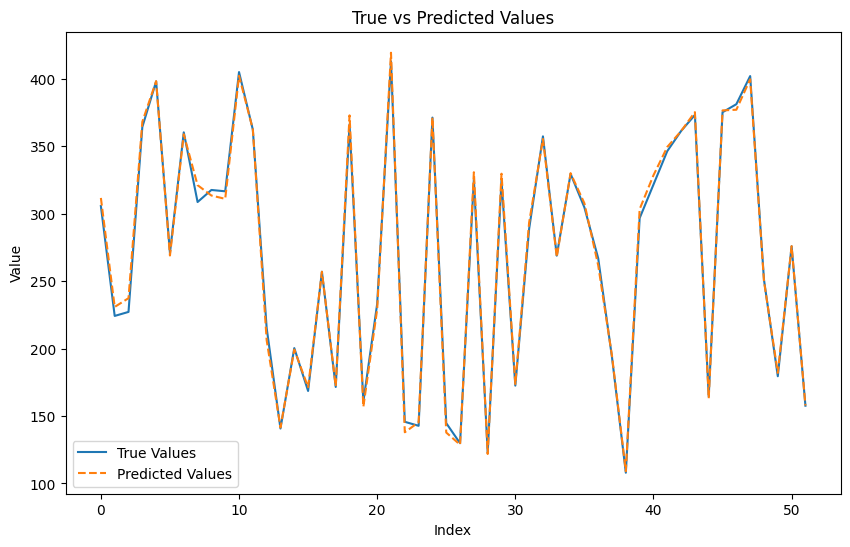

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


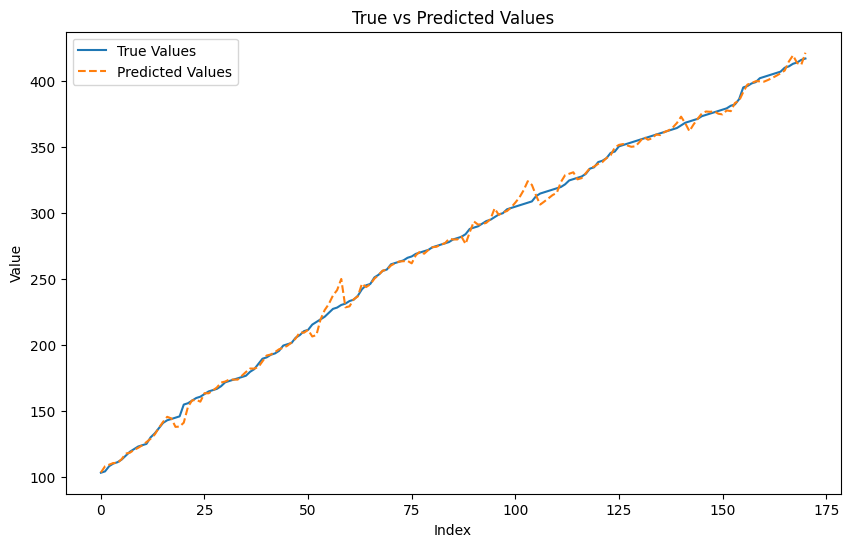

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


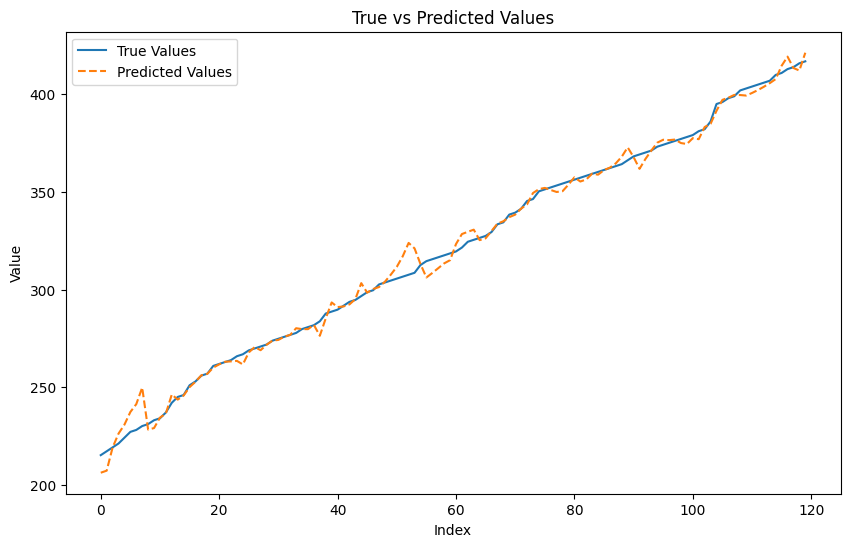

In [18]:
best_model1 = load_model(checkpoint_filepath1, custom_objects={'r_squared': r_squared})
y_test_pred1 = plot_true_vs_predicted(best_model1, x_test, y_test, target_scaler)
y_pred1 = plot_true_vs_predicted(best_model1, X, y, target_scaler)
y_final_pred1 = plot_true_vs_predicted(best_model1, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final1 = target_scaler.inverse_transform(y_final_pred1.reshape(-1, 1))
inverse_scaled_y_Predict1 = target_scaler.inverse_transform(y_pred1.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


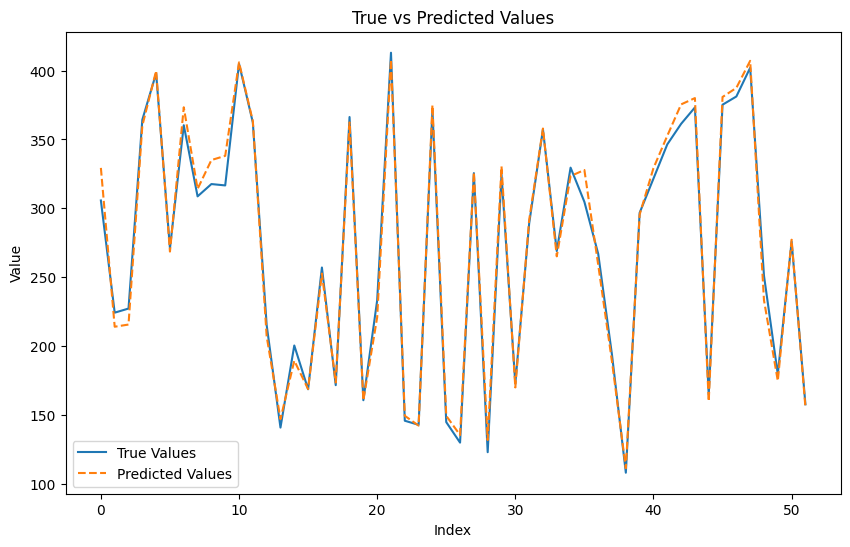

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


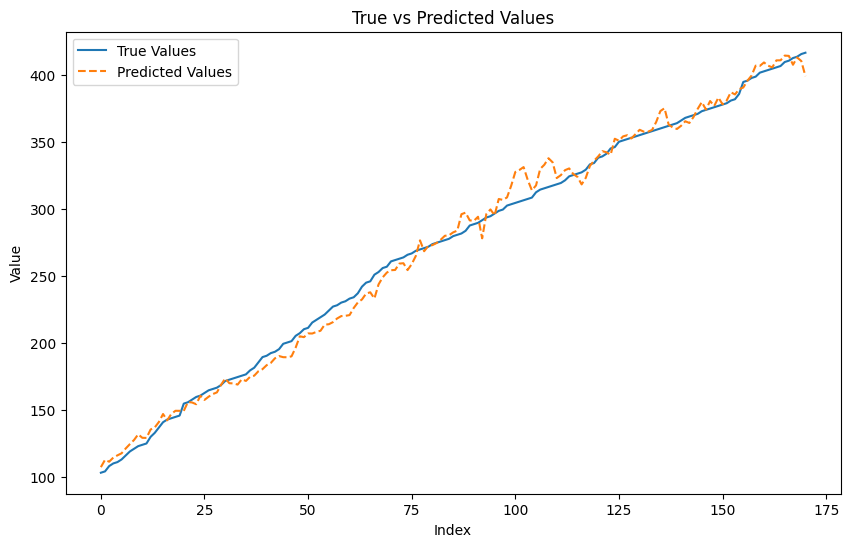

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


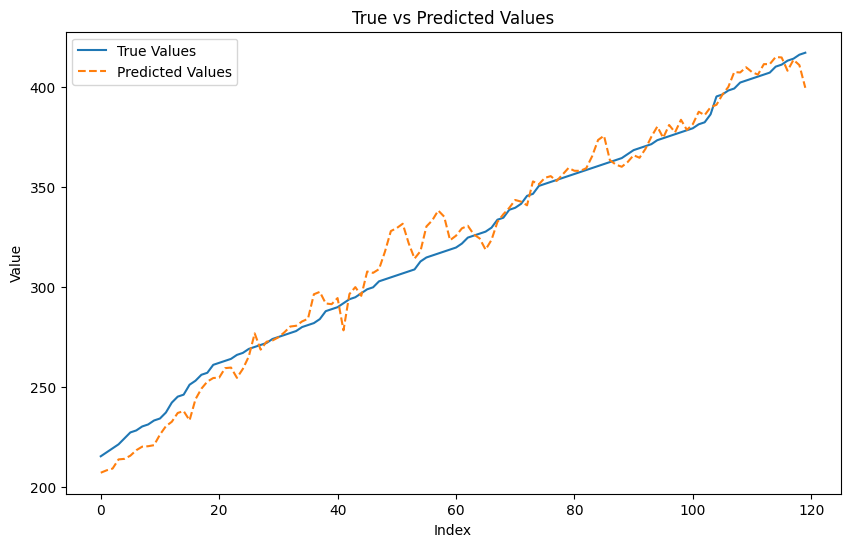

In [19]:
model.save('best_model_transformer.keras')

best_model2 = load_model('best_model_transformer.keras', custom_objects={'r_squared': r_squared})
## best_model2 = load_model(checkpoint_filepath2, custom_objects={'r_squared': r_squared})
y_test_pred2 = plot_true_vs_predicted(best_model2, x_test, y_test, target_scaler)
y_pred2 = plot_true_vs_predicted(best_model2, X, y, target_scaler)
y_final_pred2 = plot_true_vs_predicted(best_model2, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final2 = target_scaler.inverse_transform(y_final_pred2.reshape(-1, 1))
inverse_scaled_y_Predict2 = target_scaler.inverse_transform(y_pred2.reshape(-1, 1))

In [20]:
# 1. Prediksi data training dan testing
y_train_pred = best_model2.predict(x_train)
y_test_pred = best_model2.predict(x_test)

# Inverse transform data training (aktual & prediksi)
inverse_scaled_y_train = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred = target_scaler.inverse_transform(y_train_pred.reshape(-1, 1))

# Inverse transform data testing (aktual & prediksi)
inverse_scaled_y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


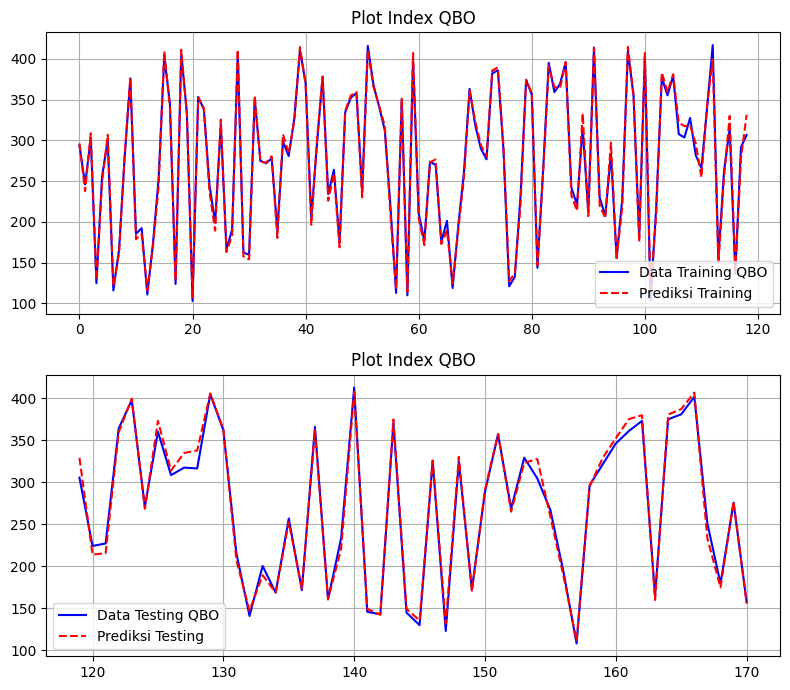

In [21]:
# Asumsikan variabel berikut sudah ada dan sudah inverse_transform:
inverse_scaled_y_train, inverse_scaled_y_train_pred
inverse_scaled_y_test, inverse_scaled_y_test_pred

# Untuk mendapatkan index global pada data test (misal setelah train 0-369, test 370-419)
train_len = len(inverse_scaled_y_train)
test_len = len(inverse_scaled_y_test)
train_idx = np.arange(train_len)
test_idx = np.arange(train_len, train_len + test_len)

plt.figure(figsize=(8, 7))

# --------- Subplot 1: Data Training ----------
plt.subplot(2, 1, 1)
plt.plot(train_idx, inverse_scaled_y_train, 'b-', label='Data Training QBO')
plt.plot(train_idx, inverse_scaled_y_train_pred, 'r--', label='Prediksi Training')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

# --------- Subplot 2: Data Testing ----------
plt.subplot(2, 1, 2)
plt.plot(test_idx, inverse_scaled_y_test, 'b-', label='Data Testing QBO')
plt.plot(test_idx, inverse_scaled_y_test_pred, 'r--', label='Prediksi Testing')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
def r_squared(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

In [23]:
def calculate_metrics_and_print(original_data, predictions):
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(original_data, predictions)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # R-squared (R2)
    r2 = r2_score(original_data, predictions)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(original_data, predictions)

    # Log Likelihood
    residuals = original_data - predictions
    log_likelihood = np.sum(norm.logpdf(residuals))

    # Mean Absolute Percentage Error (MAPE)
    ape = np.abs((original_data - predictions) / original_data)
    mape = np.mean(ape) * 100

    # Print the metrics
    print("Metrics for Original Data Model:")
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("R-squared: ", r2)
    print("MAE: ", mae)
    print("Log Likelihood: ", log_likelihood)
    print("MAPE: ", mape)

In [24]:
calculate_metrics_and_print(y, y_pred1)

Metrics for Original Data Model:
MSE:  0.0013798448305873073
RMSE:  0.037146262673212596
R-squared:  0.9979483306550824
MAE:  0.02314596562100553
Log Likelihood:  -46559.52017262629
MAPE:  273.13631186059


In [25]:
calculate_metrics_and_print(y, y_pred2)

Metrics for Original Data Model:
MSE:  0.004824783661110136
RMSE:  0.06946066268838887
R-squared:  0.9928261058678997
MAE:  0.05438715921857578
Log Likelihood:  -46924.31260395275
MAPE:  279.80610108249266


In [26]:
calculate_metrics_and_print(y_test,y_test_pred1)

Metrics for Original Data Model:
MSE:  0.001614116323383186
RMSE:  0.04017606654941703
R-squared:  0.9976195486217836
MAE:  0.030252796796874093
Log Likelihood:  -4337.873365257572
MAPE:  194.04549898490455


In [27]:
calculate_metrics_and_print(y_test,y_test_pred2)

Metrics for Original Data Model:
MSE:  0.006358240801877191
RMSE:  0.07973857787719311
R-squared:  0.9906230530844665
MAE:  0.05966011588729714
Log Likelihood:  -4367.762600983125
MAPE:  197.46346971496436


In [28]:
inverse_scaled_target = target_scaler.inverse_transform(y.reshape(-1, 1))
inverse_scaled_y_final = target_scaler.inverse_transform(y_final.reshape(-1, 1))

In [29]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict1)

Metrics for Original Data Model:
MSE:  16.429485781161095
RMSE:  4.053330208749479
R-squared:  0.99794833125194
MAE:  2.525643473879879
Log Likelihood:  -1561.8595234672725
MAPE:  1.0093936075367316


In [30]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict2)

Metrics for Original Data Model:
MSE:  57.44755122952755
RMSE:  7.5794162855412255
R-squared:  0.9928261086755774
MAE:  5.934624084318096
Log Likelihood:  -5068.904119302604
MAPE:  2.4675073550726916


In [31]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final1)

Metrics for Original Data Model:
MSE:  20.019505686584996
RMSE:  4.474316225590788
R-squared:  0.9937127016529693
MAE:  2.8895470863812656
Log Likelihood:  -1311.4429651796609
MAPE:  0.9737983458423416


In [32]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final2)

Metrics for Original Data Model:
MSE:  68.5953597935215
RMSE:  8.282231570870348
R-squared:  0.9784570359031003
MAE:  6.337575855677662
Log Likelihood:  -4225.99421159585
MAPE:  2.1401233662768377


In [33]:
# --- LSTM ---
# Prediksi di data test (10%)
y_test_pred_lstm = best_model1.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_lstm = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_lstm = target_scaler.inverse_transform(y_test_pred_lstm.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (LSTM)
print("=== Metrics Test Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_test_lstm, inverse_scaled_y_test_pred_lstm)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_lstm = best_model1.predict(x_train)
inverse_scaled_y_train_lstm = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_lstm = target_scaler.inverse_transform(y_train_pred_lstm.reshape(-1, 1))
print("=== Metrics Train Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_train_lstm, inverse_scaled_y_train_pred_lstm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
=== Metrics Test Set - LSTM ===
Metrics for Original Data Model:
MSE:  19.218880704064226
RMSE:  4.383934386377632
R-squared:  0.9976195518272198
MAE:  3.3011254757492106
Log Likelihood:  -547.475702032313
MAPE:  1.3364509359014927
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
=== Metrics Train Set - LSTM ===
Metrics for Original Data Model:
MSE:  15.210594781983076
RMSE:  3.900076253354936
R-squared:  0.9980933019365594
MAE:  2.1867779019298874
Log Likelihood:  -1014.3840749793492
MAPE:  0.8664780607780509


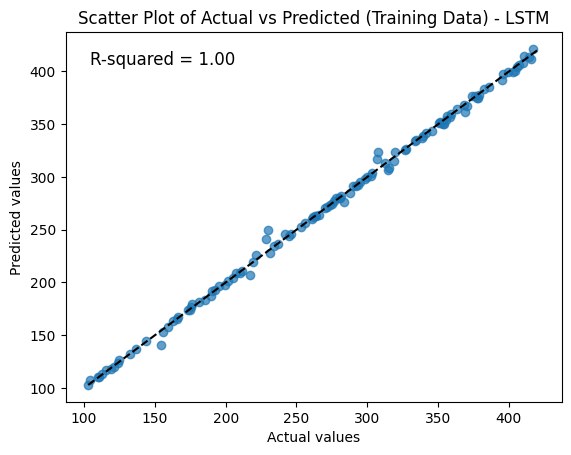

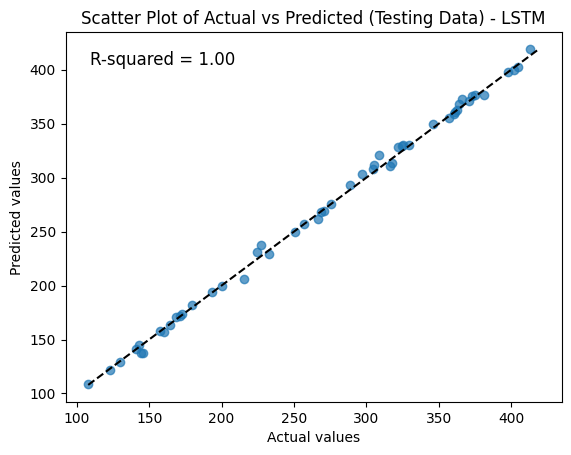

In [34]:
def plot_r2_scatter(y_true, y_pred, title, ax=None):
    r2 = r2_score(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, alpha=0.7)
    # Garis diagonal y=x
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')
    ax.text(0.05, 0.95, f'R-squared = {r2:.2f}', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top')
    ax.set_title(title)
    ax.set_xlabel("Actual values")
    ax.set_ylabel("Predicted values")

# --- LSTM ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_lstm, 
    inverse_scaled_y_train_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Training Data) - LSTM"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_lstm, 
    inverse_scaled_y_test_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - LSTM"
)
plt.show()

In [35]:
# --- TRANSFORMER ---
# Prediksi di data test (10%)
y_test_pred_transformer = best_model2.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_transformer = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_transformer = target_scaler.inverse_transform(y_test_pred_transformer.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (Transformer)
print("=== Metrics Test Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_test_transformer, inverse_scaled_y_test_pred_transformer)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_transformer = best_model2.predict(x_train)
inverse_scaled_y_train_transformer = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_transformer = target_scaler.inverse_transform(y_train_pred_transformer.reshape(-1, 1))
print("=== Metrics Train Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_train_transformer, inverse_scaled_y_train_pred_transformer)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
=== Metrics Test Set - Transformer ===
Metrics for Original Data Model:
MSE:  75.70603951243054
RMSE:  8.700921762229019
R-squared:  0.9906230593653836
MAE:  6.5099975556622525
Log Likelihood:  -2016.1418310498366
MAPE:  2.5767395540572333
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
=== Metrics Train Set - Transformer ===
Metrics for Original Data Model:
MSE:  49.46905126525832
RMSE:  7.033423865036027
R-squared:  0.9937988917856497
MAE:  5.6832002543291456
Log Likelihood:  -3052.7622357342257
MAPE:  2.419775555894617


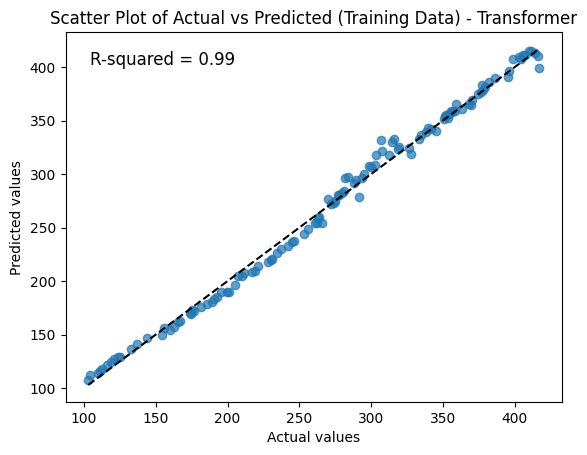

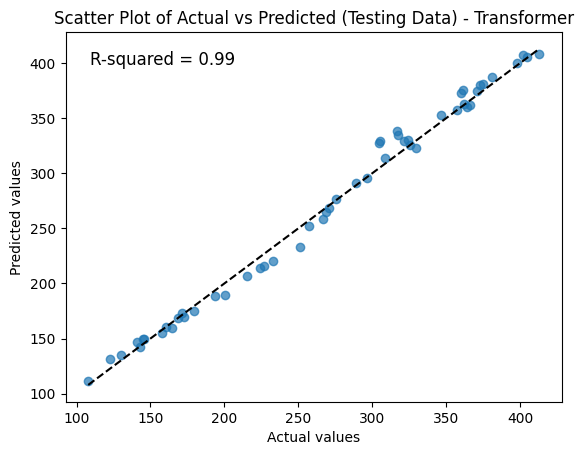

In [36]:
# --- TRANSFORMER ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_transformer, 
    inverse_scaled_y_train_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Training Data) - Transformer"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_transformer, 
    inverse_scaled_y_test_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - Transformer"
)
plt.show()

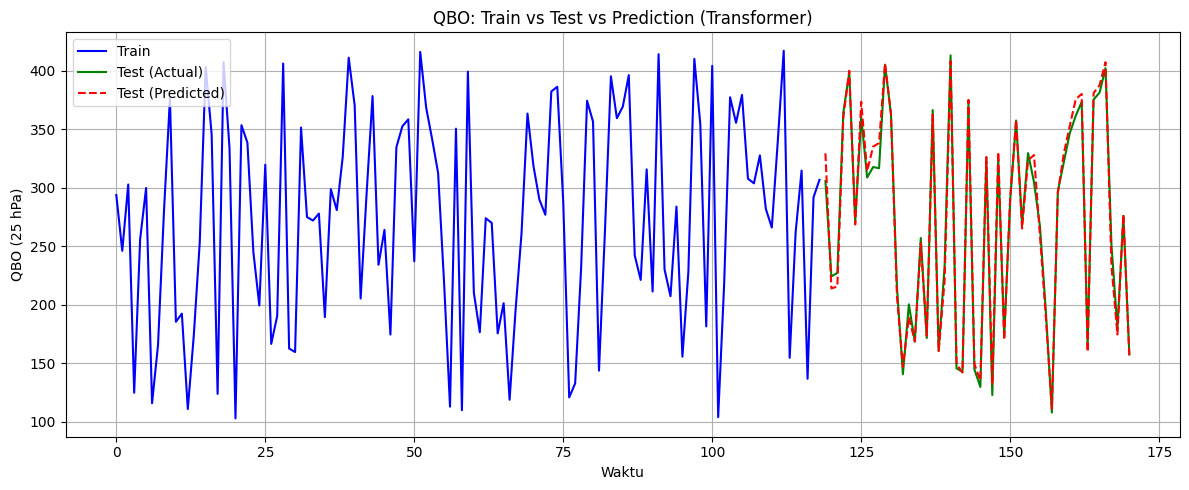

In [37]:
# Misal train_len = jumlah data train
train_len = len(inverse_scaled_y_train)
test_len = len(inverse_scaled_y_test)
train_idx = np.arange(train_len)
test_idx = np.arange(train_len, train_len + test_len)

plt.figure(figsize=(12,5))

# Plot data train (aktual)
plt.plot(train_idx, inverse_scaled_y_train, 'b-', label='Train')

# Plot data test (aktual)
plt.plot(test_idx, inverse_scaled_y_test, 'g-', label='Test (Actual)')

# Plot data test (prediksi)
plt.plot(test_idx, inverse_scaled_y_test_pred, 'r--', label='Test (Predicted)')

plt.title('QBO: Train vs Test vs Prediction (Transformer)')
plt.xlabel('Waktu')
plt.ylabel('QBO (25 hPa)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

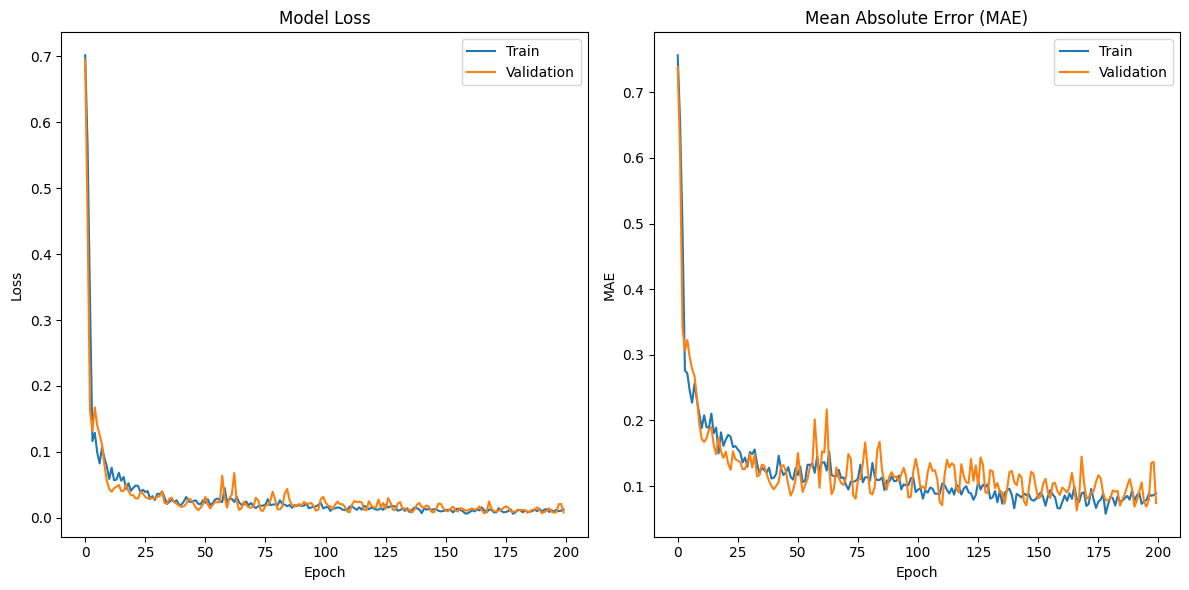

In [38]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation metrics values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error (MAE)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

In [39]:
residuals1 = inverse_scaled_target - inverse_scaled_y_Predict1
residuals_final1 = inverse_scaled_y_final - inverse_scaled_y_pred_final1

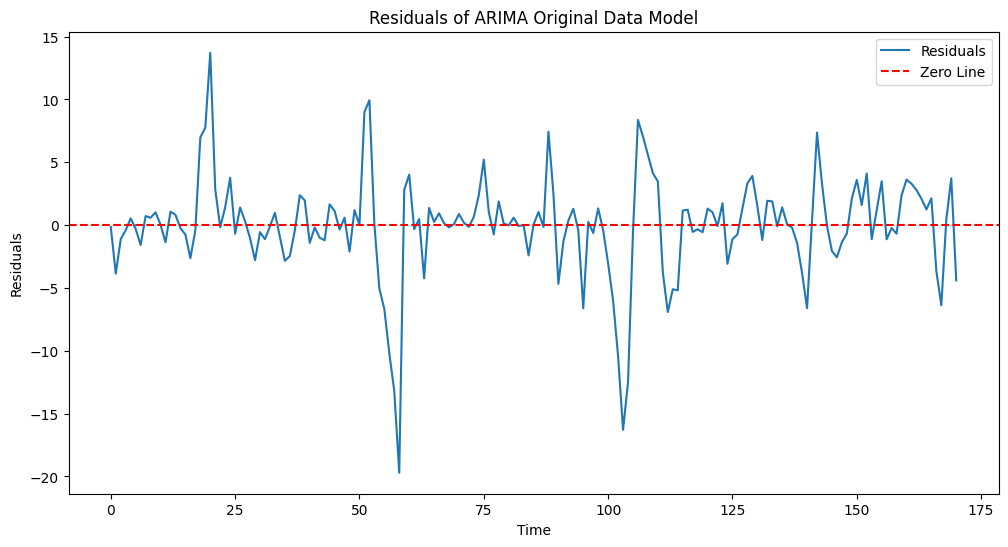

In [40]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

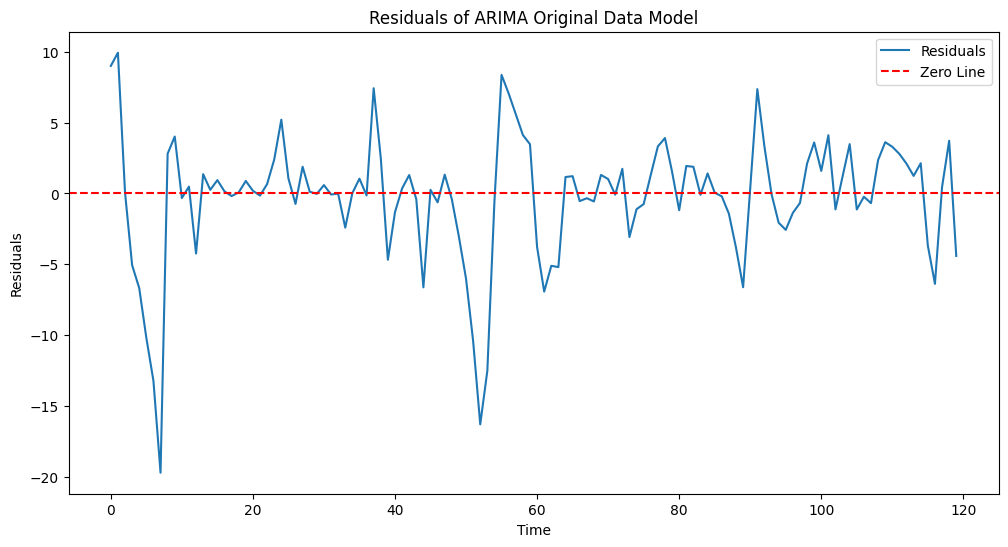

In [41]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [42]:
residuals2 = inverse_scaled_target - inverse_scaled_y_Predict2
residuals_final2 = inverse_scaled_y_final - inverse_scaled_y_pred_final2

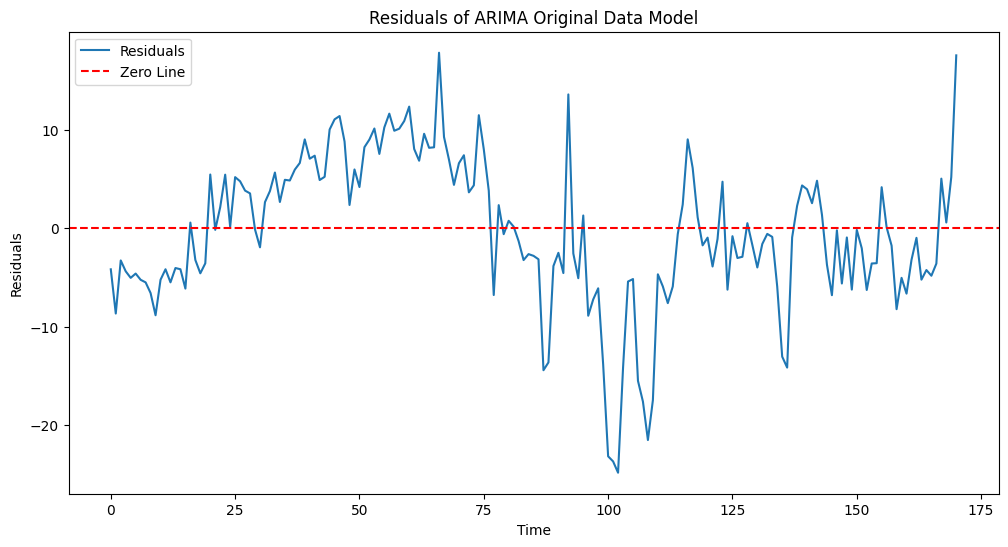

In [43]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

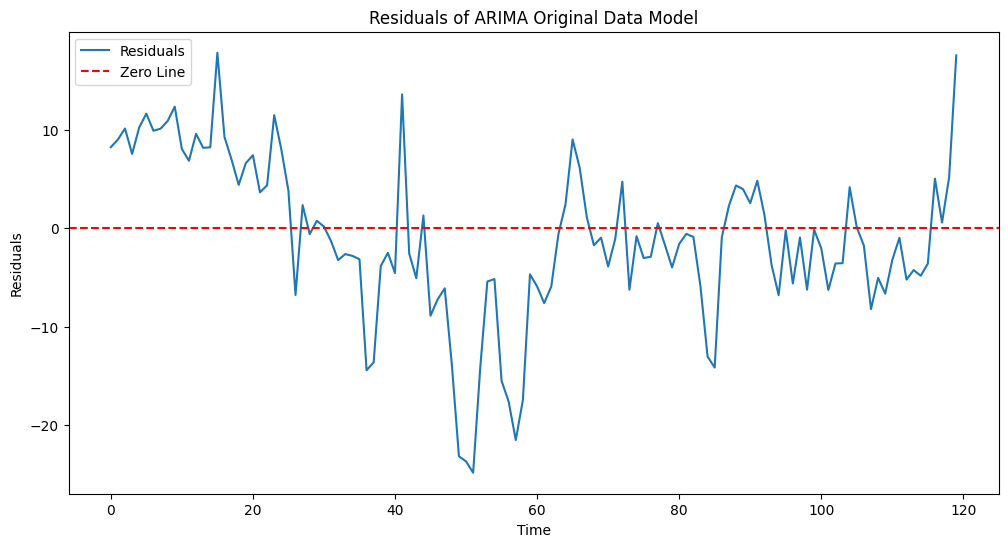

In [44]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [45]:
def residual_analysis(residuals):
    # Shapiro-Wilk Test for normality
    stat, p_value = shapiro(residuals)
    print("Shapiro-Wilk Test (Normality):")
    print("Test Statistic:", stat)
    print("P-value:", p_value)
    if p_value > 0.05:
        print("The residuals appear to be normally distributed.")
    else:
        print("The residuals may not be normally distributed.")

    # Anderson-Darling Test for normality
    result = anderson(residuals)
    test_statistic = result.statistic
    critical_values = result.critical_values

    # Plot ACF and PACF on residuals
    plt.figure(figsize=(12, 6))
    acf_res = plot_acf(residuals, title='ACF of Residuals')
    pacf_res = plot_pacf(residuals, title='PACF of Residuals')
    plt.show()

    # Plot histogram of residuals
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

Shapiro-Wilk Test (Normality):
Test Statistic: 0.8767470579015701
P-value: 1.1793826316005784e-10
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

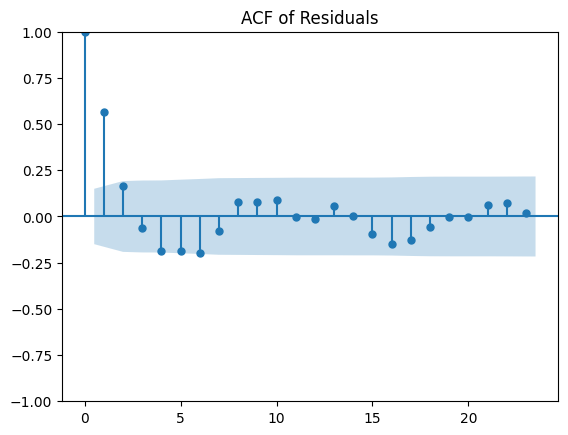

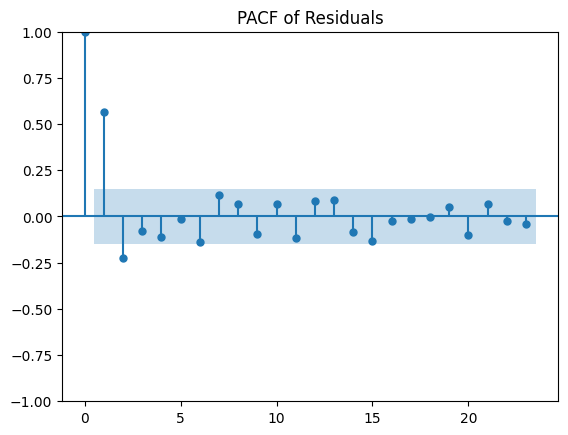

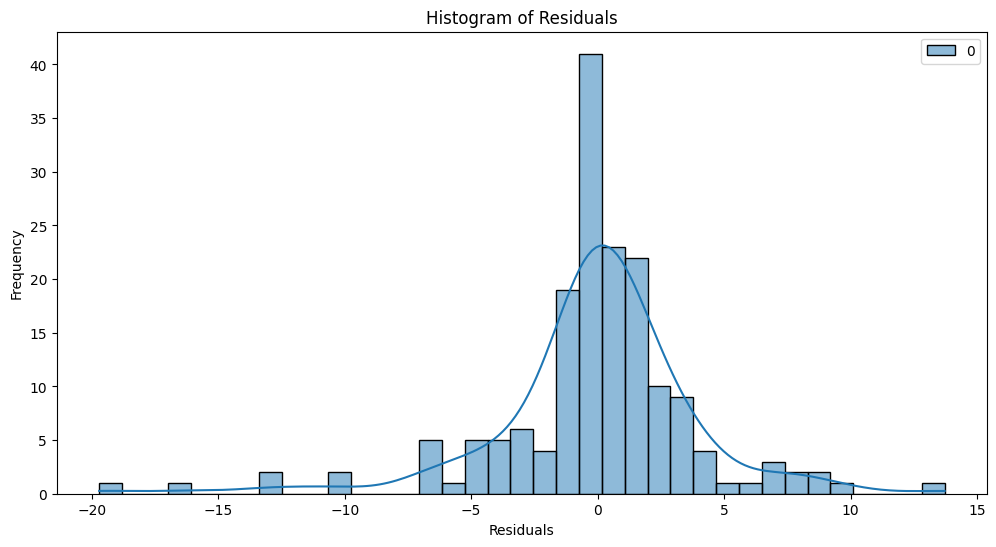

In [46]:
residual_analysis(residuals1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.8872094309719774
P-value: 4.5903446919024885e-08
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

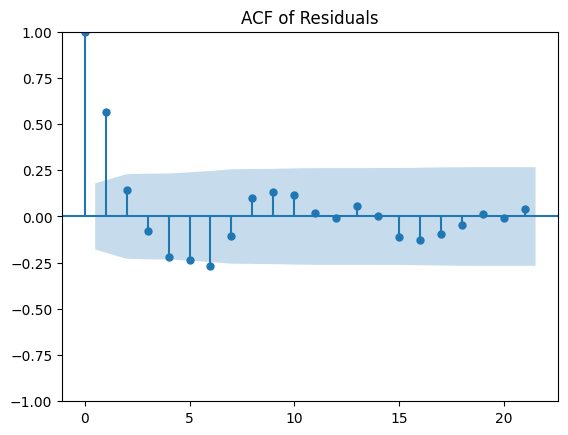

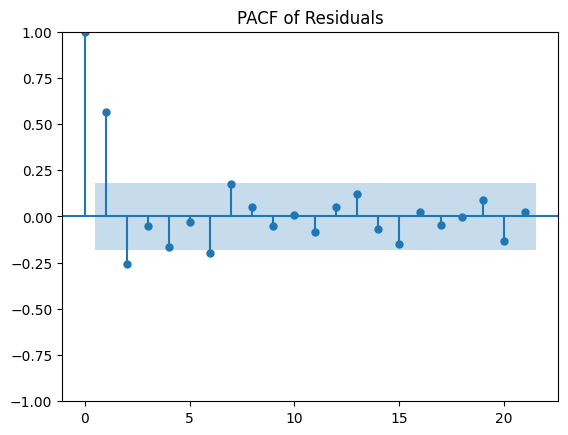

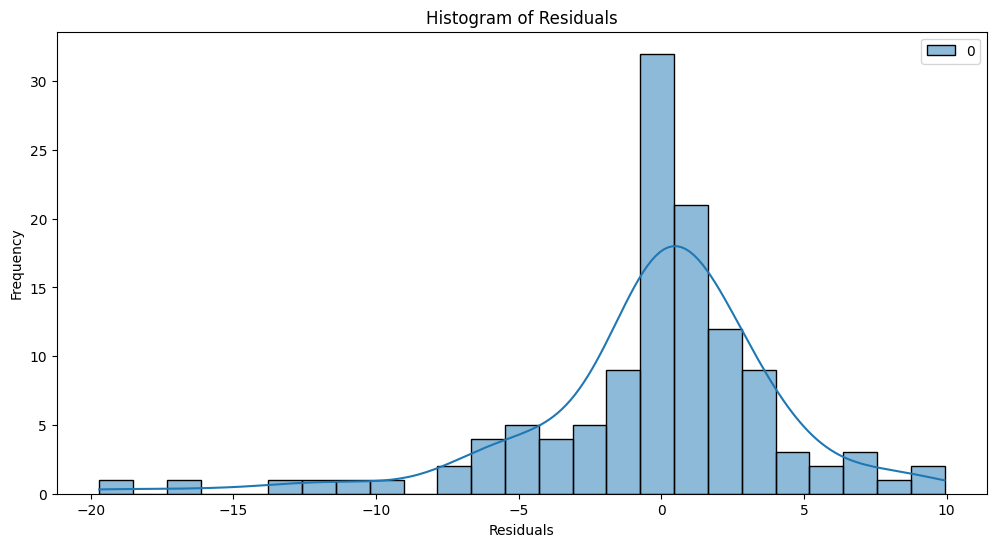

In [47]:
residual_analysis(residuals_final1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9687266556153757
P-value: 0.000674070789477776
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

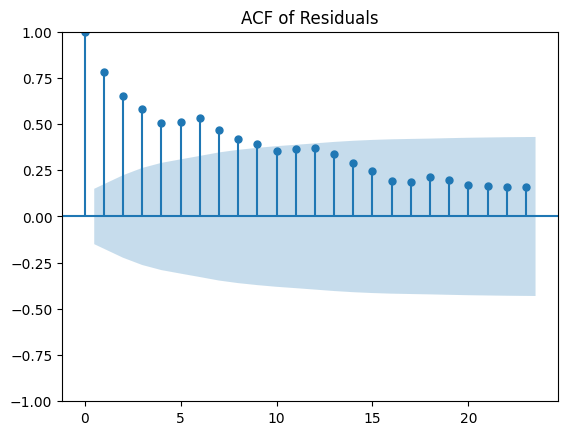

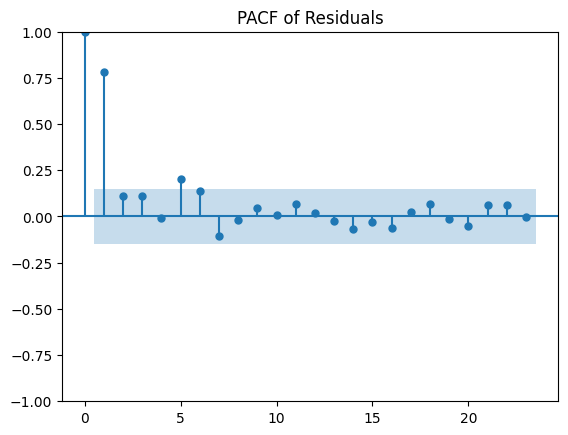

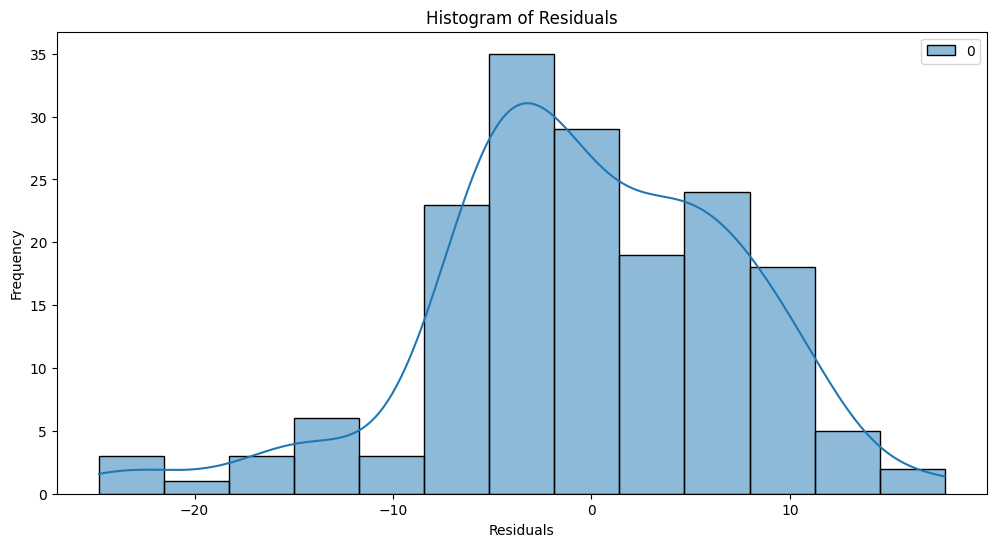

In [48]:
residual_analysis(residuals2)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9697815483638684
P-value: 0.008391238450119796
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

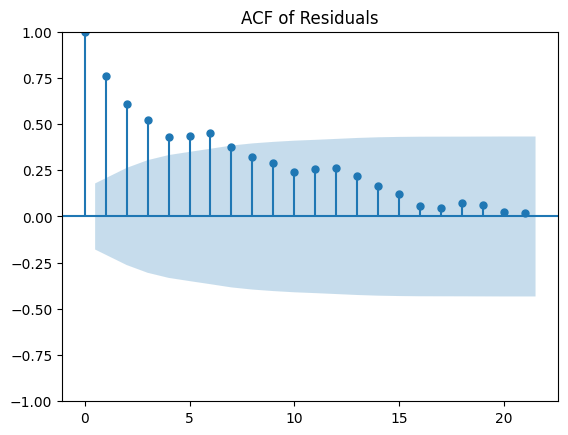

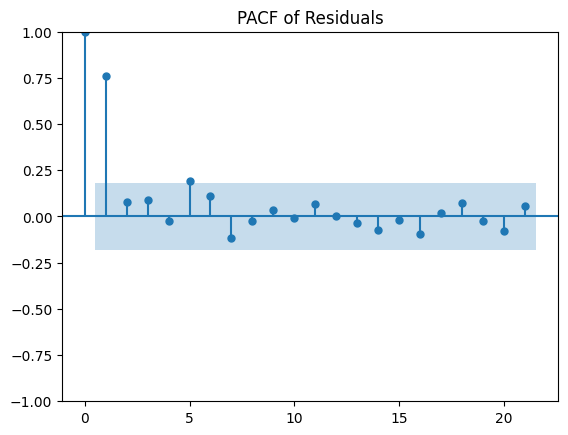

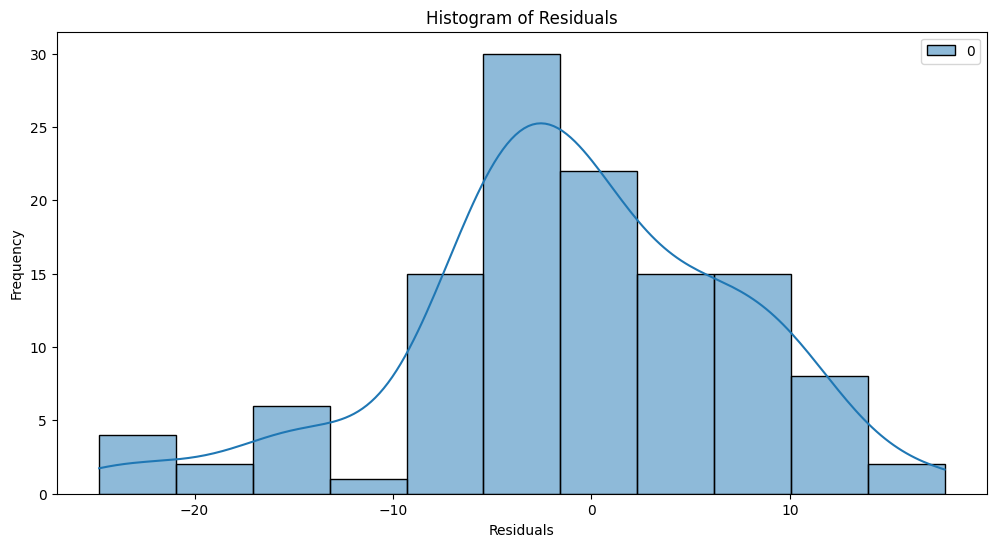

In [49]:
residual_analysis(residuals_final2)